In [289]:
import lightkurve
import eleanor
import pickle
import csv
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from lightkurve import search_lightcurvefile
from numpy import loadtxt
from astroquery.mast import Tesscut
from astroquery.mast import Catalogs
from astropy.io import fits
from lowess_detrend import lowess_detrending
from utility_belt import phase_fold_plot
from astropy.timeseries import BoxLeastSquares
from lc_download_methods import two_min_lc_download
from utility_belt import bin
plt.ion()

Setup

In [279]:
save_path = '/Users/mbattley/Documents/PhD/Kepler-2min xmatch/'
#target_ID = "27769688"
#sector=12
target_ID = "405687343"
Kepler_name = 'K00971.01'
planet_letter = 'b'
TIC = int(target_ID)
sector=14
multi_sector = False
source = 'planet_data'
#source = 't0s'

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Optional: Get planet/candidate details from file

In [280]:
data = Table.read(save_path + 'Kepler_pcs_reobserved_in_TESS_2min.csv', format='ascii.csv')
planet_params = Table(names=('periods','t0is'))
for j in range(len(data['TICID'])):
    if data['TICID'][j] == int(target_ID):
        #pcs
        period = data['koi_period'][j]
        t0 = data['koi_time0'][j]
        #planets
        #period = data['pl_orbper'][j]
        #t0 = data['pl_tranmid'][j]
        i=j
        planet_params.add_row((period, t0))
        
#with open(save_path + 'Final t0s/TESS t0s for {} {}.csv'.format(Kepler_name, planet_letter), 'r') as read_obj:
#    csv_reader = csv.reader(read_obj)
#    t0s = np.array(next(csv_reader))
#    sds = np.array(next(csv_reader))
#    t0s = np.array([float(d) - 2457000 for d in t0s])
#    sds = np.array([float(d) for d in sds])

if source == 'planet_data':
    period = planet_params['periods'][0]
    t0 = planet_params['t0is'][0]-2457000
    #t0 = t0s[0]
else:
    period = t0s[1]-t0s[0]
    t0 = t0s[0]

print(period)
print(t0)
print(i)

0.533059312
-1995.7730000000447
332


Read in TESS data

In [281]:
if (data['S14'][i] != 0) and (data['S15'][i] != 0) and (data['S26'][i] != 0):
    multi_sector = [14,15,26]
elif (data['S14'][i] != 0) and (data['S15'][i] != 0):
    multi_sector = [14,15]
elif (data['S14'][i] != 0) and (data['S26'][i] != 0):
    multi_sector = [14,26]

multi_sector = False
if multi_sector != False:
    sap_lc, pdcsap_lc = two_min_lc_download(TIC, sector = multi_sector[0], from_file = False)
    lc = pdcsap_lc
    nancut = np.isnan(lc.flux) | np.isnan(lc.time)
    lc = lc[~nancut]
    for sector_num in multi_sector[1:]:
        sap_lc_new, pdcsap_lc_new = two_min_lc_download(TIC, sector_num, from_file = False)
        lc_new = pdcsap_lc_new
        nancut = np.isnan(lc_new.flux) | np.isnan(lc_new.time)
        lc_new = lc_new[~nancut]
        lc = lc.append(lc_new)
else:
    sap_lc, pdcsap_lc = two_min_lc_download(target_ID, sector = sector, from_file = False)
    lc = pdcsap_lc
    nancut = np.isnan(lc.flux) | np.isnan(lc.time)
    lc = lc[~nancut]
    #lcf = search_lightcurvefile(target_ID, sector=sector).download()
    #pdcsap_lc = lcf.PDCSAP_FLUX
    #header_0 = lcf
    #lc = pdcsap_lc
    #nancut = np.isnan(lc.flux) | np.isnan(lc.time)
    #lc = lc[~nancut]
    print('Removed nans')
time_TESS = np.array(lc.time) #n.b. in TJD (TESS Time)
time_TESS_orig = np.array([float(str(element).strip()) for element in time_TESS]) + 2457000 #Convert to BJD for consistency
flux_TESS = lc.flux
flux_TESS_orig = np.array(flux_TESS)/np.median(flux_TESS) -1 #Normalizes and sets mean to zero, as in exoplanet tutorial
flux_err_TESS = lc.flux_err/np.median(flux_TESS)
mean_flux_err_TESS = np.mean(flux_err_TESS)


TIC 405687343
Removed nans


1682.8693121118263


<IPython.core.display.Javascript object>


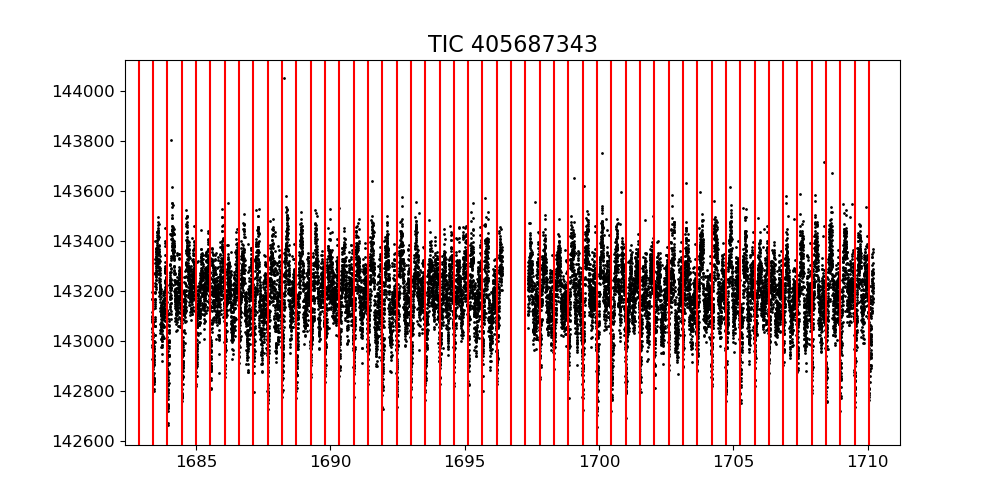

(1682.3558752274487, 1711.2057710304523)

In [282]:
from utility_belt import binned

binned_time, binned_flux = binned(time_TESS, flux_TESS, binsize=10)

current_t0 = t0
t0s = []
while current_t0 + period < time_TESS[0]:
    current_t0 = current_t0 + period
print(current_t0)
while current_t0 < time_TESS[-1]:
    t0s = t0s + [current_t0]
    current_t0 = current_t0 + period
    
#with open(save_path + 'Final t0s/TESS t0s for {} {}.csv'.format(Kepler_name, planet_letter), 'r') as read_obj:
#    csv_reader = csv.reader(read_obj)
#    t0s = np.array(next(csv_reader))
#    sds = np.array(next(csv_reader))
#    t0s = np.array([float(d)-2457000 for d in t0s])
#    sds = np.array([float(d) for d in sds])

plt.figure(figsize=(10,5))
plt.scatter(time_TESS,flux_TESS,s=1,c='k')
#plt.scatter(binned_time, binned_flux,s=2,c='r')
for t0i in t0s:
    plt.axvline(x=t0i, c='r')
plt.title("TIC {}".format(target_ID))
plt.xlim(min(time_TESS)-1,max(time_TESS)+1)

In [283]:
t0s

[1682.8693121118263,
 1683.4023714238263,
 1683.9354307358262,
 1684.4684900478262,
 1685.0015493598262,
 1685.5346086718262,
 1686.0676679838261,
 1686.6007272958261,
 1687.133786607826,
 1687.666845919826,
 1688.199905231826,
 1688.732964543826,
 1689.266023855826,
 1689.799083167826,
 1690.332142479826,
 1690.865201791826,
 1691.398261103826,
 1691.931320415826,
 1692.4643797278259,
 1692.9974390398258,
 1693.5304983518258,
 1694.0635576638258,
 1694.5966169758258,
 1695.1296762878258,
 1695.6627355998257,
 1696.1957949118257,
 1696.7288542238257,
 1697.2619135358257,
 1697.7949728478256,
 1698.3280321598256,
 1698.8610914718256,
 1699.3941507838256,
 1699.9272100958256,
 1700.4602694078255,
 1700.9933287198255,
 1701.5263880318255,
 1702.0594473438255,
 1702.5925066558254,
 1703.1255659678254,
 1703.6586252798254,
 1704.1916845918254,
 1704.7247439038254,
 1705.2578032158253,
 1705.7908625278253,
 1706.3239218398253,
 1706.8569811518253,
 1707.3900404638252,
 1707.9230997758252,
 1

In [284]:
current_t0

1710.588396335825

In [285]:
time_TESS[-1]

1710.2057710304523

<IPython.core.display.Javascript object>


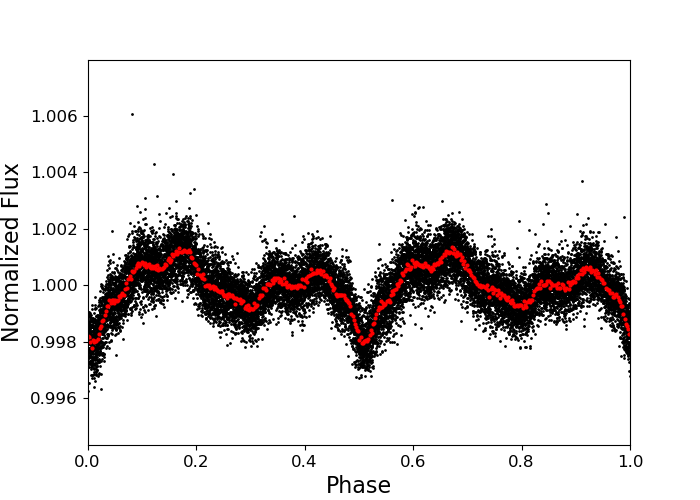

In [296]:
epoch=t0
period = period*2
phase = np.mod(time_TESS-epoch-period/2,period)/period

flux_TESS = flux_TESS/np.median(flux_TESS)

plt.figure(figsize=(7,5))
plt.scatter(phase,flux_TESS,s=1,c='k')
plt.xlim(0,1)
#plt.ylim(0.996,1.004)
plt.text(0.74, 0.94, 'P = {:.4} days'.format(period))
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
sort_array = np.argsort(phase)
new_phase = phase[sort_array]
new_lc = flux_TESS[sort_array]
binned_phase, binned_lc = bin(new_phase, new_lc, binsize=40, method='mean')
plt.scatter(binned_phase, binned_lc, c='r', s=4)